In [32]:
import torch
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
import pyvista as pv
pv.start_xvfb()


import plotly.graph_objects as go
import plotly.express as px


%load_ext autoreload
%autoreload 2
from help_functions.make_conv_2d_torch import make_conv_2d_torch
from help_functions.make_conv_3d_torch import make_conv_3d_torch
from help_functions.morph_fill import morph_fill, morph_fill_fast
from help_functions.Sub_AT_torch import Sub_AT_torch
from help_functions.Sub_A_torch import Sub_A_torch
from help_functions.solve_least_squares_subdivision import solve_least_squares_subdivision
from help_functions.plot_subdivision_points import plot_subdivision_points
# from help_functions.solve_least_squares_subdivision import apply_C
from help_functions.shadows_visual import shadows_visual, shadows_visual_UI, shadows_visual_volume_plotly
from help_functions.fast_optimization import (Sub_A_fast, 
                                              Sub_AT_fast, 
                                              solve_least_squares_subdivision_fast,
                                              solve_least_squares_subdivision_CG)

from help_functions.make_html_visual import make_html_visual
from help_functions.make_scatter_visual import make_scatter_visual

from IPython.display import HTML
import kaleido
import plotly.io as pio



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Flood fill:  79%|███████▊  | 30049/38220 [00:01<00:00, 25600.77px/s]


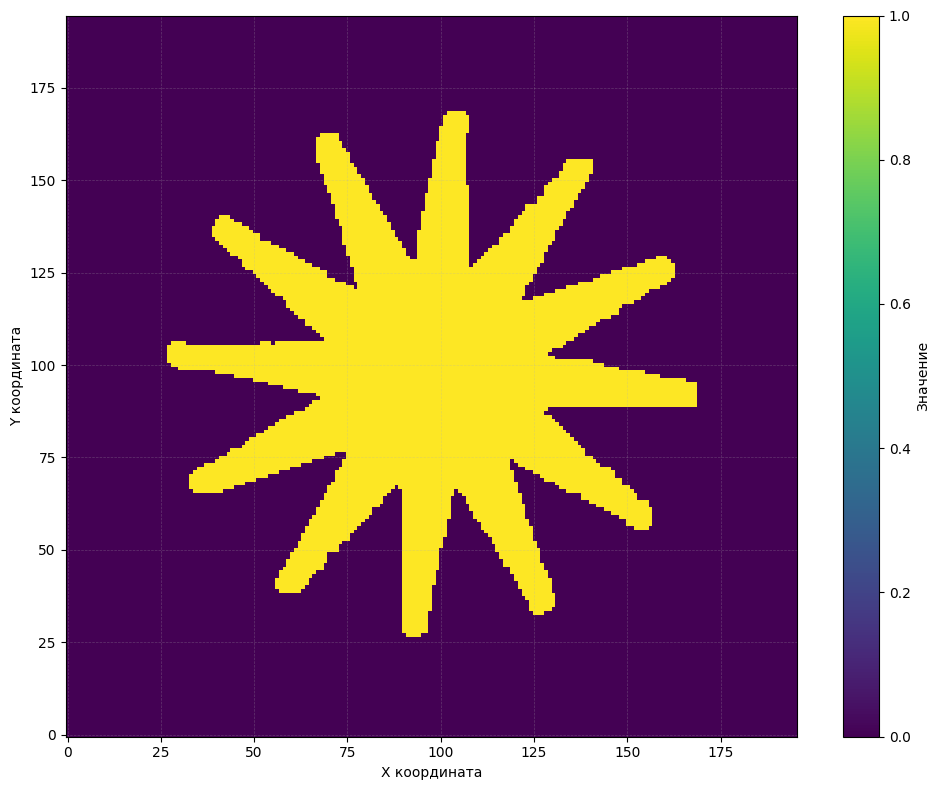

In [3]:
# Читаем файл и получаем изображение
coef = 3.5
raw_data = np.loadtxt('./models/Turbine.txt').reshape(-1)
int_cast_data = np.trunc(raw_data*coef*np.power(10,0)).astype(int).reshape(-1, 3)

shifted = (int_cast_data - int_cast_data.min(axis=0) + 1*np.array([10,10,10]))
sizes = (int_cast_data.max(axis=0) - int_cast_data.min(axis=0) + 1*np.array([20,20, 20])).astype(int)

tensor_3d = torch.zeros(tuple(sizes), dtype=int)
tensor_3d[shifted[:, 0], shifted[:, 1], shifted[:, 2]] = 1

#Берем срез
turbine_slice = tensor_3d[:,:, 55]

#Утолщаем границы единичной сверткой
kernel_shape = 3
turbine_slice_conv_result = make_conv_3d_torch(source=turbine_slice, kernel=torch.ones(size=(kernel_shape,kernel_shape,kernel_shape)))

#Морфологически заполняем срез
turbine_slice_conv_filled = morph_fill(turbine_slice_conv_result)

plt.figure(figsize=(10, 8))
    
plt.imshow(turbine_slice_conv_filled, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/turbine_slice_conv_filled.png')
plt.show()


In [4]:
turbine_slice_conv_filled.shape

torch.Size([195, 196])

In [28]:
mask = torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4

# Z - характористическая функция поверхности
Z = turbine_slice_conv_filled


x0 = solve_least_squares_subdivision_CG(Z, mask, j = 3, tol = 1e-6, max_iter=1000)
# z_rec = Sub_A_torch(mask, x0)

# error = torch.norm(z_rec - Z)
# print(error)

CG ITER 0: residual = 1.210193e+02
CG ITER 1: residual = 4.417245e+01
CG ITER 2: residual = 3.220818e+01
CG ITER 3: residual = 1.962934e+01
CG ITER 4: residual = 1.119863e+01
CG ITER 5: residual = 7.874492e+00
CG ITER 6: residual = 5.456059e+00
CG ITER 7: residual = 3.845031e+00
CG ITER 8: residual = 2.537916e+00
CG ITER 9: residual = 2.082951e+00
CG ITER 10: residual = 1.570040e+00
CG ITER 11: residual = 1.215043e+00
CG ITER 12: residual = 9.501148e-01
CG ITER 13: residual = 7.467496e-01
CG ITER 14: residual = 5.766961e-01
CG ITER 15: residual = 4.545469e-01
CG ITER 16: residual = 3.230765e-01
CG ITER 17: residual = 2.532796e-01
CG ITER 18: residual = 1.839572e-01
CG ITER 19: residual = 1.490096e-01
CG ITER 20: residual = 1.222614e-01
CG ITER 21: residual = 1.052763e-01
CG ITER 22: residual = 8.975824e-02
CG ITER 23: residual = 7.877623e-02
CG ITER 24: residual = 6.988573e-02
CG ITER 25: residual = 6.661169e-02
CG ITER 26: residual = 5.678263e-02
CG ITER 27: residual = 5.612142e-02
CG

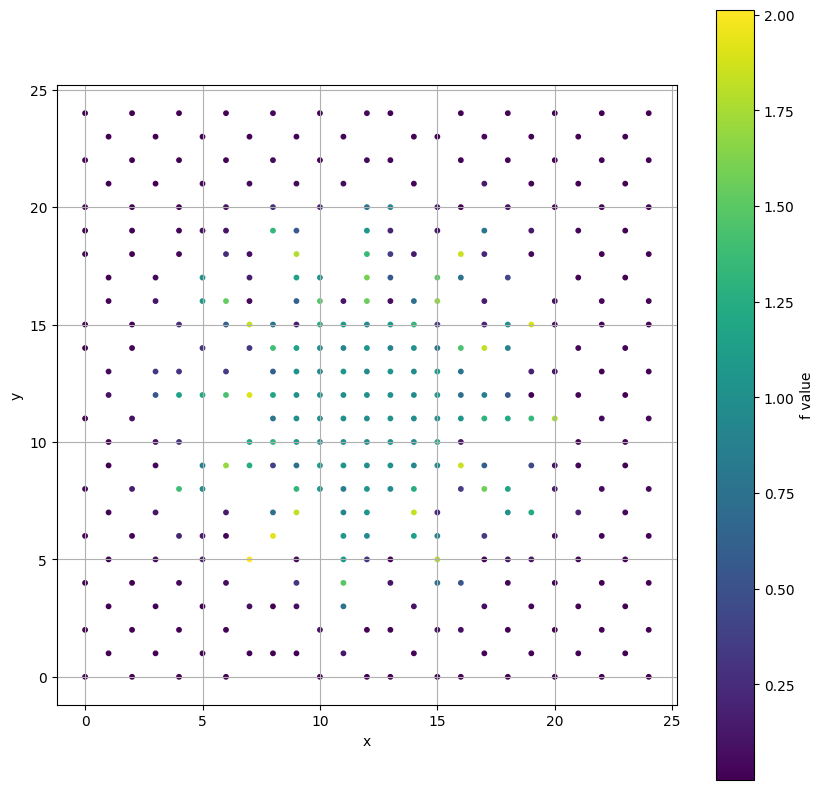

In [29]:
plot_subdivision_points(x0, threshold=0, do_ceil=False)

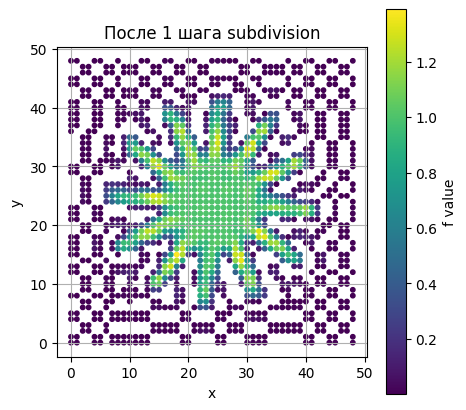

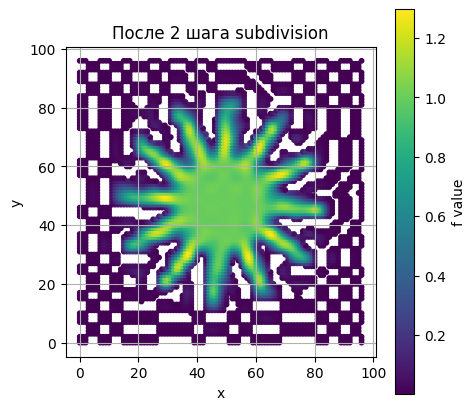

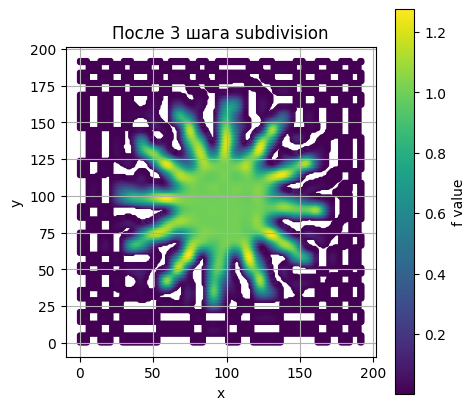

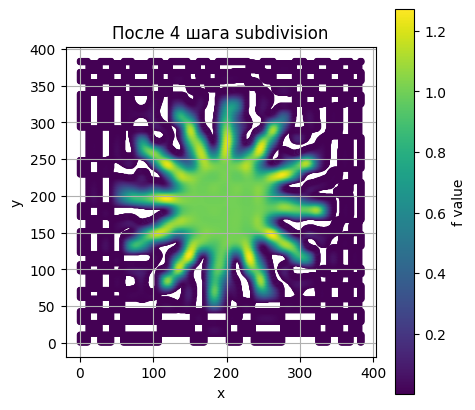

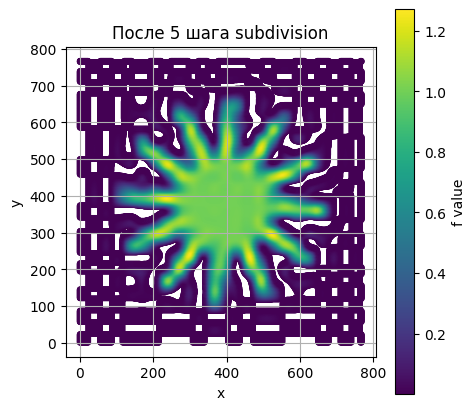

In [30]:
mask = torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4

x0_subdivisioned = x0.clone()
k = 2
for i in range(5):
    x0_subdivisioned = Sub_A_torch(mask, x0_subdivisioned)
    plot_subdivision_points(
        x0_subdivisioned,
        threshold=0.00,
        title=f"После {i+1} шага subdivision",
        figsize=(5,5),
        do_ceil= False,
        visual_type= 'scatter'
    )
    k *=2
    # print(k)

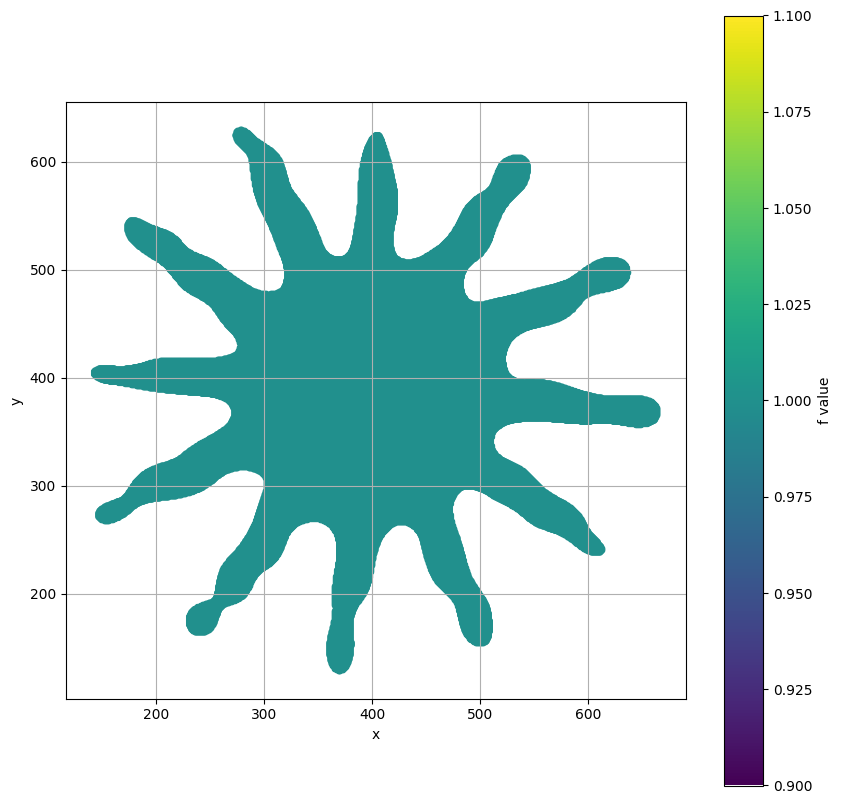

In [31]:
threshold = 0.8
# x0_clone_filtered = torch.where(x0_clone > threshold, x0_clone, torch.tensor(0.0))

x0_clone_filtered_ceil = (x0_subdivisioned > threshold).float()
plot_subdivision_points(data = x0_clone_filtered_ceil,
                        threshold=0.0,
                        title='',
                        figsize=(10,10),
                        do_ceil=False,
                        visual_type='scatter')